In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


## Generate a fixed delta function input signal

Text(0.5, 1.0, 'output signal')

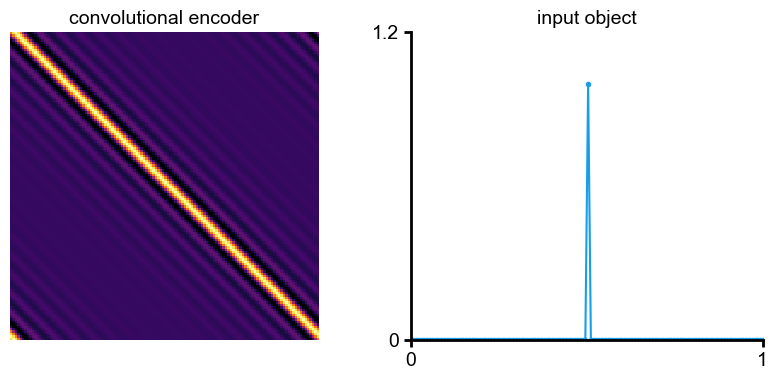

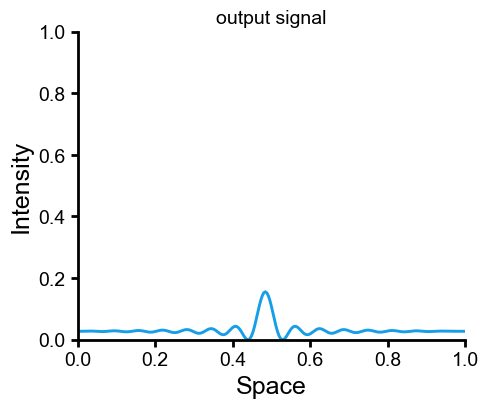

In [26]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function
# input_signal = bandlimited_nonnegative_signal(delta_function)


# generate the convolutional encoder
nyquist_samples = onp.zeros(NUM_NYQUIST_SAMPLES)
nyquist_samples[-1] = 1
kernel = bandlimited_nonnegative_signal(nyquist_samples=np.array(nyquist_samples))

conv_mat = make_convolutional_encoder(kernel)
conv_mat_for_display = make_convolutional_encoder(kernel, sample=False)

# plot the input signal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(conv_mat_for_display, cmap='inferno', interpolation='none')
ax[0].set_title('convolutional encoder')
# remove axes
ax[0].axis('off')


ax[1].plot(np.linspace(0,1, input_signal.size), input_signal,  '.-', label='input signal',)
ax[1].set_title('input object')
ax[1].set(xlim=(0,1))
default_format(ax[1])


# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal')
ax.set_title('output signal')

# Optimize the convolution matrix to map a delta towards a target signal

In [32]:

# generate a delta function target signal (cant be achieved because of bandlimit)
use_sampling_indices = True
sampling_indices = (3, 4)
# num_nyquist_samples = NUM_NYQUIST_SAMPLES
num_nyquist_samples = NUM_NYQUIST_SAMPLES // 2

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signal = onp.zeros_like(generate_concentrated_signal(sampling_indices, num_nyquist_samples=num_nyquist_samples))
# target_signal[sampling_indices[0]] = 1
target_signal[sampling_indices[0]] = 0.5
target_signal[sampling_indices[1]] = 0.5

target_signal = np.array(target_signal)
# target_signal = bandlimited_nonnegative_signal(target_signal)


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)
loss_fn = make_convolutional_forward_model_and_loss_fn(input_signal, target_signal, sampling_indices=sampling_indices if use_sampling_indices else None, num_nyquist_samples=num_nyquist_samples)
optimized_params = run_optimzation(loss_fn, lambda x : real_imag_bandlimit_energy_norm_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                         np.concatenate(real_imag_params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)), learning_rate=1e-3, verbose=True)
optimized_kernel = signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params, num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel, num_nyquist_samples=num_nyquist_samples)
initial_conv_mat = make_convolutional_encoder(initial_kernel, num_nyquist_samples=num_nyquist_samples)




initial loss 0.35660076


# Make a grid of points to use as loss function targets

100%|██████████| 55/55 [41:21<00:00, 45.12s/it]


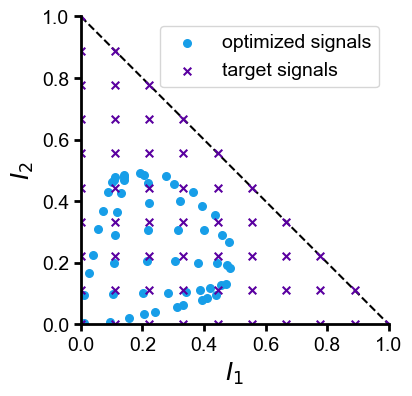

In [ ]:

sampling_indices = (3, 4)
num_grid_points = 10
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points)

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal, sampling_indices=sampling_indices)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

## Smaller signal SBP

  0%|          | 0/78 [00:00<?, ?it/s]

initial loss 0.011361547


  1%|▏         | 1/78 [00:12<15:54, 12.39s/it]

initial loss 0.0101538375


  3%|▎         | 2/78 [00:38<25:55, 20.46s/it]

initial loss 0.025475055


  4%|▍         | 3/78 [01:07<30:15, 24.21s/it]

initial loss 0.0573252


  5%|▌         | 4/78 [01:58<43:10, 35.00s/it]

initial loss 0.10570426


  6%|▋         | 5/78 [02:38<44:36, 36.67s/it]

initial loss 0.17061228


  8%|▊         | 6/78 [03:02<38:42, 32.25s/it]

initial loss 0.25204918


  9%|▉         | 7/78 [03:12<29:55, 25.29s/it]

initial loss 0.35001498


 10%|█         | 8/78 [03:29<26:24, 22.64s/it]

initial loss 0.4645098


 12%|█▏        | 9/78 [03:42<22:30, 19.57s/it]

initial loss 0.59553355


 13%|█▎        | 10/78 [03:58<20:45, 18.31s/it]

initial loss 0.7430861


 14%|█▍        | 11/78 [04:10<18:26, 16.52s/it]

initial loss 0.9071676


 15%|█▌        | 12/78 [04:21<16:13, 14.75s/it]

initial loss 0.002718429


 17%|█▋        | 13/78 [04:49<20:23, 18.82s/it]

initial loss 0.0015107199


 18%|█▊        | 14/78 [05:08<20:06, 18.85s/it]

initial loss 0.016831938


 19%|█▉        | 15/78 [05:24<18:56, 18.04s/it]

initial loss 0.04868208


 21%|██        | 16/78 [05:43<18:57, 18.35s/it]

initial loss 0.09706114


 22%|██▏       | 17/78 [06:10<21:21, 21.01s/it]

initial loss 0.16196916


 23%|██▎       | 18/78 [06:53<27:32, 27.55s/it]

initial loss 0.24340606


 24%|██▍       | 19/78 [07:09<23:40, 24.08s/it]

initial loss 0.3413719


 26%|██▌       | 20/78 [07:24<20:31, 21.23s/it]

initial loss 0.4558667


 27%|██▋       | 21/78 [07:41<19:04, 20.08s/it]

initial loss 0.58689046


 28%|██▊       | 22/78 [07:58<17:49, 19.10s/it]

initial loss 0.734443


 29%|██▉       | 23/78 [08:22<18:58, 20.69s/it]

initial loss 0.010604237


 31%|███       | 24/78 [08:44<18:47, 20.89s/it]

initial loss 0.009396528


 32%|███▏      | 25/78 [09:02<17:39, 19.98s/it]

initial loss 0.024717744


 33%|███▎      | 26/78 [09:19<16:41, 19.26s/it]

initial loss 0.05656789


 35%|███▍      | 27/78 [09:34<15:21, 18.07s/it]

initial loss 0.10494695


 36%|███▌      | 28/78 [09:52<14:59, 17.99s/it]

initial loss 0.16985497


 37%|███▋      | 29/78 [10:17<16:23, 20.07s/it]

initial loss 0.25129187


 38%|███▊      | 30/78 [10:47<18:25, 23.03s/it]

initial loss 0.34925768


 40%|███▉      | 31/78 [11:12<18:31, 23.64s/it]

initial loss 0.46375248


 41%|████      | 32/78 [11:26<15:46, 20.57s/it]

initial loss 0.5947763


 42%|████▏     | 33/78 [11:38<13:37, 18.17s/it]

initial loss 0.035018973


 44%|████▎     | 34/78 [12:06<15:25, 21.04s/it]

initial loss 0.033811264


 45%|████▍     | 35/78 [12:23<14:16, 19.93s/it]

initial loss 0.04913248


 46%|████▌     | 36/78 [12:41<13:34, 19.39s/it]

initial loss 0.080982625


 47%|████▋     | 37/78 [12:59<12:51, 18.82s/it]

initial loss 0.12936169


 49%|████▊     | 38/78 [13:24<13:46, 20.66s/it]

initial loss 0.1942697


 50%|█████     | 39/78 [13:50<14:25, 22.19s/it]

initial loss 0.2757066


 51%|█████▏    | 40/78 [14:45<20:25, 32.25s/it]

initial loss 0.37367243


 53%|█████▎    | 41/78 [15:49<25:41, 41.65s/it]

initial loss 0.48816723


 54%|█████▍    | 42/78 [16:26<24:12, 40.36s/it]

initial loss 0.075962625


 55%|█████▌    | 43/78 [16:52<21:03, 36.09s/it]

initial loss 0.074754916


 56%|█████▋    | 44/78 [17:10<17:19, 30.56s/it]

initial loss 0.09007613


 58%|█████▊    | 45/78 [17:28<14:43, 26.76s/it]

initial loss 0.12192628


 59%|█████▉    | 46/78 [17:52<13:51, 25.97s/it]

initial loss 0.17030534


 60%|██████    | 47/78 [18:18<13:24, 25.97s/it]

initial loss 0.23521335


 62%|██████▏   | 48/78 [18:58<15:08, 30.28s/it]

initial loss 0.31665027


 63%|██████▎   | 49/78 [20:04<19:44, 40.85s/it]

initial loss 0.41461608


 64%|██████▍   | 50/78 [21:15<23:17, 49.92s/it]

initial loss 0.13343523


 65%|██████▌   | 51/78 [21:58<21:32, 47.88s/it]

initial loss 0.13222753


 67%|██████▋   | 52/78 [22:24<17:50, 41.17s/it]

initial loss 0.14754874


 68%|██████▊   | 53/78 [22:42<14:17, 34.31s/it]

initial loss 0.17939888


 69%|██████▉   | 54/78 [22:57<11:25, 28.55s/it]

initial loss 0.22777794


 71%|███████   | 55/78 [23:32<11:40, 30.46s/it]

initial loss 0.29268596


 72%|███████▏  | 56/78 [23:57<10:31, 28.71s/it]

initial loss 0.37412286


 73%|███████▎  | 57/78 [24:53<12:59, 37.12s/it]

initial loss 0.20743673


 74%|███████▍  | 58/78 [25:32<12:31, 37.56s/it]

initial loss 0.20622902


 76%|███████▌  | 59/78 [26:21<13:00, 41.07s/it]

initial loss 0.22155023


 77%|███████▋  | 60/78 [26:53<11:32, 38.45s/it]

initial loss 0.2534004


 78%|███████▊  | 61/78 [27:35<11:07, 39.29s/it]

initial loss 0.30177945


 79%|███████▉  | 62/78 [28:34<12:04, 45.26s/it]

initial loss 0.36668745


 81%|████████  | 63/78 [29:53<13:51, 55.41s/it]

initial loss 0.29796714


 82%|████████▏ | 64/78 [30:30<11:40, 50.01s/it]

initial loss 0.29675943


 83%|████████▎ | 65/78 [31:26<11:10, 51.59s/it]

initial loss 0.31208065


 85%|████████▍ | 66/78 [32:39<11:36, 58.08s/it]

initial loss 0.34393078


 86%|████████▌ | 67/78 [33:55<11:39, 63.61s/it]

initial loss 0.39230984


 87%|████████▋ | 68/78 [35:21<11:42, 70.23s/it]

initial loss 0.40502653


 88%|████████▊ | 69/78 [35:37<08:05, 53.93s/it]

initial loss 0.40381882


 90%|████████▉ | 70/78 [35:58<05:52, 44.04s/it]

initial loss 0.41914004


 91%|█████████ | 71/78 [36:28<04:38, 39.79s/it]

initial loss 0.45099017


 92%|█████████▏| 72/78 [37:51<05:17, 52.90s/it]

initial loss 0.5286149


 94%|█████████▎| 73/78 [38:42<04:20, 52.14s/it]

initial loss 0.52740717


 95%|█████████▍| 74/78 [39:11<03:00, 45.23s/it]

initial loss 0.54272836


 96%|█████████▌| 75/78 [40:19<02:36, 52.08s/it]

initial loss 0.66873205


 97%|█████████▋| 76/78 [41:07<01:41, 50.91s/it]

initial loss 0.66752434


 99%|█████████▊| 77/78 [41:46<00:47, 47.36s/it]

initial loss 0.8253781


100%|██████████| 78/78 [42:47<00:00, 32.92s/it]

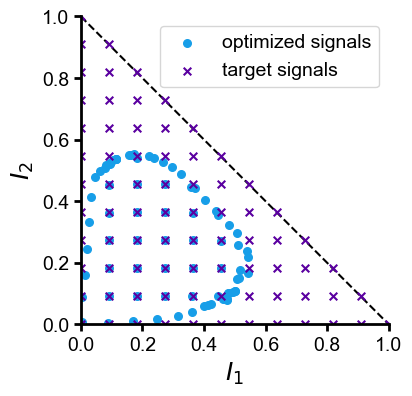

In [12]:

sampling_indices = (3, 4)
num_grid_points = 12
num_nyquist_samples = 16
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points, num_nyquist_samples=num_nyquist_samples)

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal, sampling_indices=sampling_indices, verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

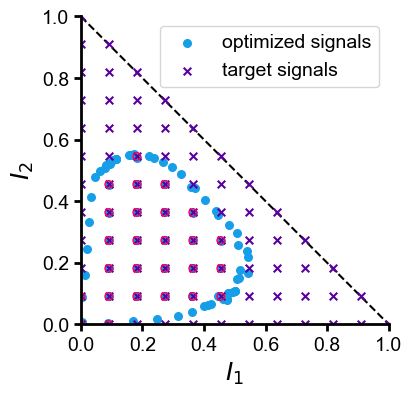

In [24]:
# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals[:, sampling_indices] - output_signals[:, sampling_indices]) ** 2, axis=1))
threshold = 0.01

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)

# plot open circles on all the ones that have a distance below a threshold
plot_in_intensity_coordinates(ax, target_signals[dist < threshold], 
                               sample_point_indices=sampling_indices, marker='o', color='none', edgecolor=get_color_cycle()[2])
ax.legend()

## Generate random signals uniform in L1 ball

In [18]:
import numpy as onp
import os

def generate_random_l1_samples(d, max_samples, batch_size):

    @partial(jax.jit, static_argnums=(1, 2))
    def random_l1_vector(key, N, d):
    # Generate a random radius and a random direction
        radius = jax.random.uniform(key, shape=(N, d,)) ** (1/d)
        key, subkey = jax.random.split(key)
        direction = jax.random.normal(subkey, shape=(N, d,))
        direction /= np.linalg.norm(direction, axis=1, keepdims=True)  # Normalize to unit length

        # Scale direction by radius and adjust to ensure all components are positive
        vectors = np.abs(radius * direction)
        mask = vectors.sum(axis=1) < 1
        return vectors, mask

    samples = []
    key = jax.random.PRNGKey(onp.random.randint(0, 1000000))
    i = 0
    if not os.path.exists(".cache"):
        os.mkdir(".cache")
    cache_filename = f".cache/{d}_dimensional_random_L1_ball_samples.npy"  # Name of the cache file
    # if it exists, load the samples from disk
    if os.path.exists(cache_filename):
        saved_samples = np.load(cache_filename, allow_pickle=True)
        print(f"Loaded {len(saved_samples)} samples from disk")
        samples.extend(saved_samples[:max_samples])

    while len(samples) < max_samples:
        vectors, mask = random_l1_vector(key, batch_size, d)
        valid_samples = vectors[mask]
        samples.extend(valid_samples)
        key, subkey = jax.random.split(key)
        print(i, len(samples), end='\r')
        i += 1
        if valid_samples.shape[0] == 0:
            continue

        # Save the valid samples to disk
        if os.path.exists(cache_filename):
            existing_samples = np.load(cache_filename, allow_pickle=True)
            combined_samples = np.concatenate([existing_samples, valid_samples], axis=0)
            np.save(cache_filename, combined_samples)
        else:
            np.save(cache_filename, valid_samples)

    return np.array(samples)

for d in [6, 8, 10, 12]:
    print(f"Generating {d}-dimensional random L1 ball samples")
    l2_ball_samples = generate_random_l1_samples(d, max_samples=500, batch_size=int(1e8))


Generating 6-dimensional random L1 ball samples
Loaded 88006 samples from disk
Generating 8-dimensional random L1 ball samples
Loaded 730 samples from disk
Generating 10-dimensional random L1 ball samples
Loaded 503 samples from disk
Generating 12-dimensional random L1 ball samples
Loaded 42 samples from disk


## Plot the randomly generated signals

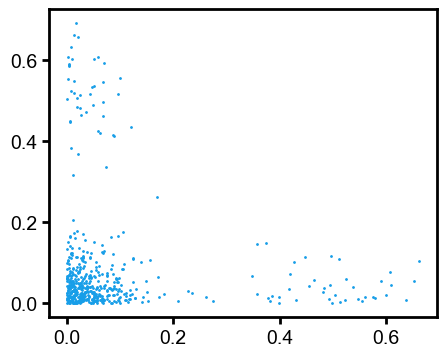

In [42]:
# load 10 dimensional samples
l1_ball_samples = np.load(".cache/12_dimensional_random_L1_ball_samples.npy", allow_pickle=True)

l1_ball_samples = np.array(l1_ball_samples)

# plot the samples
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(l1_ball_samples[:, 0], l1_ball_samples[:, 1], s=1)

## Figure out tolerance by optimizing to random signals

In [43]:
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signals = l1_ball_samples[:500]

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal)


100%|█████████▉| 498/500 [1:52:09<00:32, 16.37s/it]

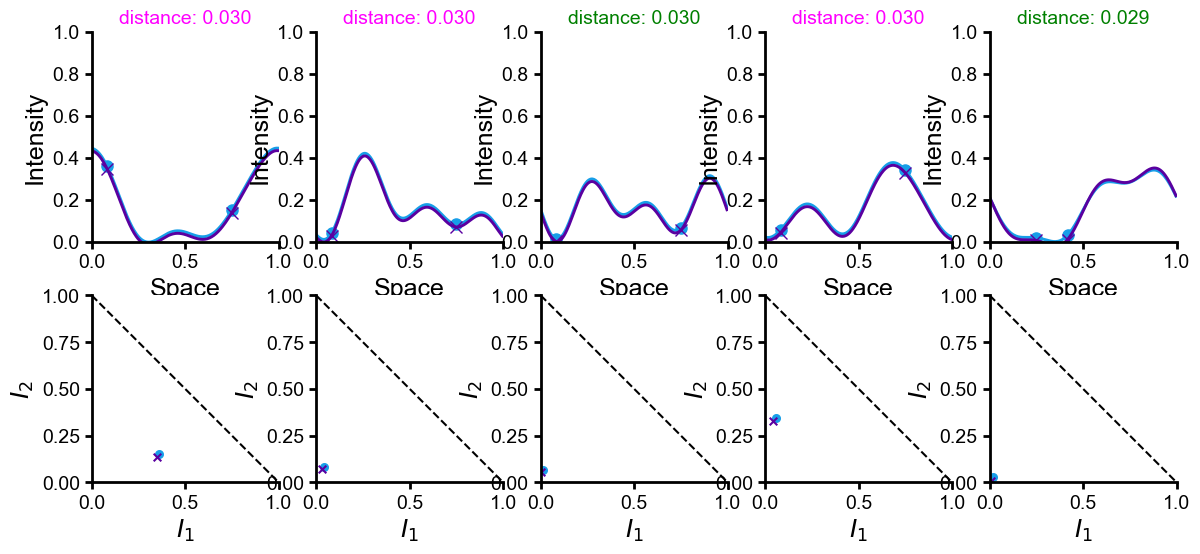

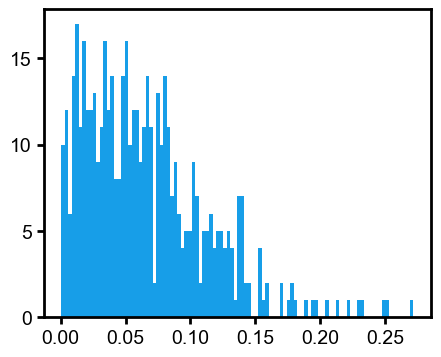

In [41]:
threshold = 0.03

# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals - output_signals) ** 2, axis=1))


# pick 6 random signals
indices = onp.random.choice(np.arange(target_signals.shape[0]), size=9, replace=False)

# pick the 6 with the lowest distance from the threshold
indices = np.argsort(np.abs(dist - threshold))[:9]


# make a 2x6 grid with spatial plots on top and intensity plots on bottom
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for i, (ax1, ax2) in enumerate(zip(ax[0], ax[1])):
    output_signal = output_signals[indices[i]]
    target_signal = target_signals[indices[i]]
    # find sampling indices, as the two where they differ the most
    sampling_indices = np.argsort(np.abs(output_signal - target_signal))[-2:]

    plot_in_spatial_coordinates(ax1, output_signal, label='optimized signals', sample_point_indices=sampling_indices,
                                color_samples=True, show_samples=True)
    plot_in_spatial_coordinates(ax1, target_signal, label='target signals', marker='x', color_samples=True,
                                sample_point_indices=sampling_indices, show_samples=True)
    plot_in_intensity_coordinates(ax2, output_signal, label='optimized signals', sample_point_indices=sampling_indices)
    plot_in_intensity_coordinates(ax2, target_signal, label='target signals', marker='x', 
                                   sample_point_indices=sampling_indices)

    dist_for_this = dist[indices[i]]
    # ax1.set_title(f'distance: {dist[random_indices[i]]:.2f}')
    # make title green if distance is below threshold
    if dist_for_this < threshold:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='green')
    else:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='magenta')
    
# plot hist of distances
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = ax.hist(dist, bins=100)

## optimize towards random signals to Monte Carlo estimate volume

In [ ]:
num_nyquist_samples = 12
threshold = 0.03


delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function


l1_ball_samples = np.array(np.load(".cache/{}_dimensional_random_L1_ball_samples.npy".format(num_nyquist_samples), allow_pickle=True))

outcomes = []
for sample in l1_ball_samples:
    success = False
    output_signal = optimize_towards_target_signals([sample], input_signal, num_nyquist_samples=num_nyquist_samples)[1][0]
    distance = np.sqrt(np.sum((sample - output_signal) ** 2))
    if distance < threshold:
        success = True
        break
    outcomes.append(success)

## How many random samples are needed to get a good estimate of the volume?

In [ ]:
# plot the success fraction as a function of the number of sample
success_fraction_estimates = np.cumsum(outcomes) / np.arange(1, len(outcomes) + 1)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(success_fraction_estimates) 
ax.set(xlabel='number of samples', ylabel='success fraction', ylim=(0, 1))
clear_spines(ax)

In [ ]:
# compute L2 distance between the output signals and the target signals
distances = np.sqrt(np.sum((np.array(output_signals) - l1_ball_samples) ** 2, axis=1))

# Volume is the fraction of the L1 positice orthant that is inside the L1 ball times the success rate on optimization
d = 10
1 / np.factorial(d) 